# Ocean Color Classifications

Here we apply simple & standard classifiers to `ocean color data` over a wide region. 

_Credit: sample data file was provided by T. Jackson from [Plymouth Marine Lab](https://www.pml.ac.uk)_

<img src="../figs/cbiomes-01.png" alt="Drawing" style="height: 100px;"/>

### Activate packages for later use

It is assumed that listed packages have aleary been installed using `julia`'s package manager (documentation available [here](https://docs.julialang.org/en/)). 

In [1]:
using OceanColorData, Plots, NCDatasets

### Observed wavebands

Currently, the `OC-CCI` [satellite data set](https://esa-oceancolour-cci.org) provides remotely sensed reflectance at 6 wavelengths (`wv_cci` in `nm`)

In [2]:
wv_cci=[412, 443, 490, 510, 555, 670];

### Optical classification using reflectances

`Fuzzy logic` classifiers defined in [Moore et al 2009](https://doi.org/10.1016/j.rse.2009.07.016) and [Jackson et al 2017](http://dx.doi.org/10.1016/j.rse.2017.03.036) can be used to assign optical class memberships from an `Rrs` vector. While Moore et al define `n=8` classes using an in-situ database, Jackson et al instead define `n=14` classes using a satellite database. The latter benefits from better data coverage across all of the ecological provinces of the global ocean and is used in `OC-CCI`. 

In both cases the classifier is encoded in a mean reflectance spectra (`M[i][1:6]`) and a covariance matrix (`S[i][1:6,1:6]`) provided for each optical class (`i` in `1:n`). Class memberships are then derived by computing the squared Mahalanobis distance to each `M[i]` and passing the result to cumulative chi-squared distribution function (Equations 11 and 12 in [Moore et al 2011](https://doi.org/10.1109/36.942555)).

In [3]:
(M,Sinv)=Jackson2017();

### Read In Data Sample

_Credit: sample data file was provided by T. Jackson from [Plymouth Marine Lab](https://www.pml.ac.uk)_

In [4]:
dir0="../samples/"; 
fil=dir0*"ESACCI-OC-RRS-sample-fv4.0.nc"
ds = Dataset(fil)

Rrs_412=ds["Rrs_412"]; Rrs_443=ds["Rrs_443"]; Rrs_490=ds["Rrs_490"]; 
Rrs_510=ds["Rrs_510"]; Rrs_555=ds["Rrs_555"]; Rrs_670=ds["Rrs_670"];
lon=ds["lon"]; lat=ds["lat"];

Plot one of the wave bands as an example.

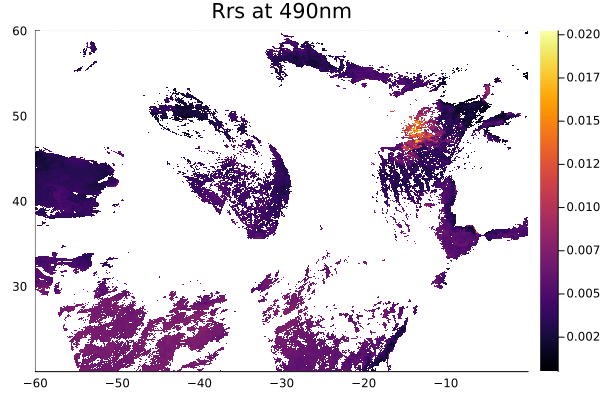

In [5]:
c=transpose(reverse(ds["Rrs_490"][:,:,1],dims=2))
heatmap(lon,reverse(lat),c,title="Rrs at 490nm")

### Compute memberships

Apply Classification to our 2D data sample and plot out a map.

In [6]:
#Find points that have a full set of input
tmp=fill(false,size(Rrs_412))
for ii in eachindex(Rrs_412)
    !ismissing(Rrs_412[ii]) ? tmp[ii]=!ismissing(Rrs_443[ii].*Rrs_490[ii].*Rrs_510[ii].*Rrs_555[ii].*Rrs_670[ii]) : nothing
end
ii=findall(tmp);

#Apply classifier
mbrshp=fill(NaN,(1440,960,14))
for jj=1:length(ii); 
    kk=ii[jj]
    Rrs_tmp=[Rrs_412[kk] Rrs_443[kk] Rrs_490[kk] Rrs_510[kk] Rrs_555[kk] Rrs_670[kk]]
    mbrshp[kk[1],kk[2],:]=FuzzyClassification(M,Sinv,vec(Rrs_tmp))
end

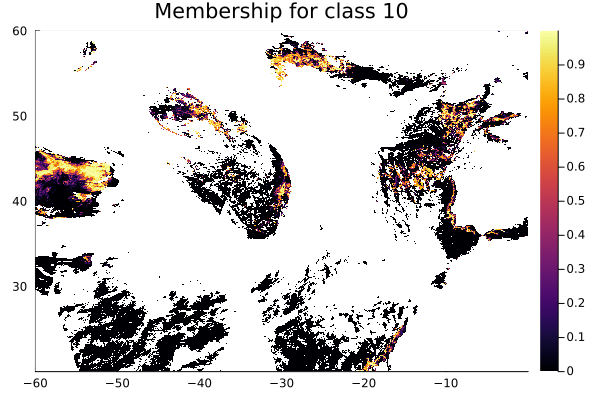

In [7]:
c=transpose(reverse(mbrshp[:,:,10],dims=2))
heatmap(lon,reverse(lat),c,title="Membership for class 10")